In [13]:
# References
# https://www.kaggle.com/code/vbmokin/nh4-tsaug-time-series-augmentation/notebook

In [133]:
from datetime import datetime, timedelta

import tsaug
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go

In [134]:
date_format = '%Y-%m-%d'
def date_parser(x):
	return datetime.strptime(x, date_format)

# map_date = np.vectorize(lambda x: datetime.fromtimestamp(x/1000.0))

In [167]:
file = './data/gcp_cost.csv'
# Date column index is 2
df = pd.read_csv(file, sep=',', header=0, parse_dates=[2],
                  date_parser=date_parser,  dtype={'gcpId': object})
df = df[['date', 'costInUsd', 'gcpId']].sort_values('date')
df = df.dropna()
instanceId = '7994828870141789187'
df_i = df[df['gcpId'] == instanceId]
df_i

,date,costInUsd,gcpId
805,2022-05-11,0.272394,7994828870141789187
3295,2022-05-12,0.920838,7994828870141789187
4041,2022-05-13,0.828322,7994828870141789187
2256,2022-05-14,0.875552,7994828870141789187
2724,2022-05-15,0.869427,7994828870141789187
...,...,...,...
1229,2022-09-23,0.881169,7994828870141789187
1602,2022-09-24,0.927295,7994828870141789187
418,2022-09-25,0.829429,7994828870141789187
3223,2022-09-26,0.401194,7994828870141789187


In [136]:
start_date = df_i.min(axis=0)['date']
end_date = df_i.max(axis=0)['date']
days_range = end_date - start_date + timedelta(days=1)
print(f"{start_date} -> {end_date}: {days_range} days", )

2022-05-11 00:00:00 -> 2022-09-27 00:00:00: 140 days 00:00:00 days


In [137]:
X = np.arange(len(df))
X_date = df_i['date'].map(lambda x: int(x.timestamp()*1000)).tolist()

In [138]:
Y = df_i['costInUsd'].tolist()
Y = np.array(Y)

In [139]:
### AUGMENTATION HERE
def add_noise(Y, X, scale=0.1):
    Y_aug_noise, X_aug_noise = tsaug.AddNoise(scale=scale).augment(Y, X)
    return Y_aug_noise, X_aug_noise

def add_drift(Y, X, max_drift=0.5, n_drift_points=5):
    Y_aug_drift, X_aug_drift = tsaug.Drift(max_drift=max_drift, n_drift_points=n_drift_points).augment(Y, X)
    return Y_aug_drift, X_aug_drift

In [140]:
Y_aug_noise, X_aug_noise = add_noise(Y, X)
Y_aug_drift, X_aug_drift = add_drift(Y, X)

ValueError: The length of series in X and Y are different.

In [141]:
def draw_plot_px2(title_plot, X_aug, Y_aug, label1, X_aug2, Y_aug2, label2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name=label1))
    fig.add_trace(go.Scatter(x=X_aug2, y=Y_aug2,
                        mode='lines',
                        name=label2))
    fig.add_trace(go.Scatter(x=X, y=Y,
                        mode='lines',
                        name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

In [142]:
draw_plot_px2('GCP_cost_March-Sept',X_aug_noise, Y_aug_noise, 'after_add_noise', X_aug_drift, Y_aug_drift, 'after_add_drift')

In [143]:
NUM_OF_PERIODS = 4
X_date_extended1 = pd.date_range(start_date -(days_range) * NUM_OF_PERIODS,start_date,freq='d').map(lambda x: int(x.timestamp()*1000))
X_date_extended = np.hstack([X_date_extended1, X_date])[1:]

In [144]:
type(X)

numpy.ndarray

In [145]:
# Start executing add extended_Y, add noise to each result
extended_Y = []
cur_Y = Y
for i in range(0, NUM_OF_PERIODS):
    cur_Y, X = add_noise(cur_Y, X)
    extended_Y.append(cur_Y)

Y_extended = np.hstack([Y] + extended_Y)

ValueError: The length of series in X and Y are different.

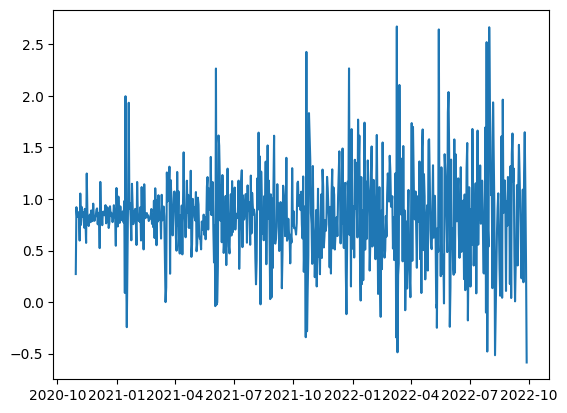

In [146]:
vfunc = np.vectorize(lambda x: datetime.fromtimestamp(x/1000.0))
plt.plot(vfunc(X_date_extended), Y_extended)

In [147]:
###MAIN

In [176]:
all_instance_ids = list(pd.Series({'instanceId': df['gcpId'].unique() for c in df}).tolist())
type(all_instance_ids)

list

In [186]:
res = {}
for instance_id in all_instance_ids[0]:
    df_instance = df[df['gcpId'] == instance_id]
    start_date = df_instance.min(axis=0)['date']
    end_date = df_instance.max(axis=0)['date']
    days_range = end_date - start_date + timedelta(days=1)
    Y = df_instance['costInUsd'].tolist()
    Y = np.array(Y)
    X = np.arange(len(df_instance))
    Y_aug_noise, X_aug_noise = add_noise(Y, X)
    Y_aug_drift, X_aug_drift = add_drift(Y, X)
    X_date_extended1 = pd.date_range(start_date -(days_range) * NUM_OF_PERIODS,start_date,freq='d').map(lambda x: int(x.timestamp()*1000))
    X_date_extended = np.hstack([X_date_extended1, X_date])[1:]
    extended_Y = []
    cur_Y = Y
    for i in range(0, NUM_OF_PERIODS):
        cur_Y, X = add_noise(cur_Y, X)
        extended_Y.append(cur_Y)

    Y_extended = np.hstack([Y] + extended_Y)
    type(res)
    res.update({
     str(instance_id):    {
        X: X_date_extended,
        Y: extended_Y
    }
    })

/root/vng/repos/data_augmentation/venv/lib/python3.8/site-packages/tsaug/_augmenter/drift.py:209: RuntimeWarning:

invalid value encountered in divide



TypeError: unhashable type: 'numpy.ndarray'

In [169]:
len(df)

4715